In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Metrics
import copy
import Padding

In [2]:
#############################
# BOGUS values
#############################

BOGUS_INT = -999

In [3]:
#############################
# Define file
#############################

file = 'networkscores_0_oneModel_JAM'
outputFile = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/' + file + '.npz'

In [4]:
#############################
# Read file
#############################

print('Reading file: ', str(outputFile),', This may take a while...')

data = np.load(outputFile)

run_in = data['run']
subrun_in = data['subrun']
event_in = data['event']
isNC_in = data['isNC']
nuPDG_in = data['nuPDG']
particleMask_in = data['particleMask']
pfpTruePDG_in = data['pfpTruePDG']
trueTrackID_in = data['trueTrackID']
trueVisibleGeneration_in = data['trueVisibleGeneration']
trueVisibleParentPDG_in = data['trueVisibleParentPDG']
trueVisibleParentPFPIndex_in = data['trueVisibleParentPFPIndex']
trueGeneration_in = data['trueGeneration']
trueParentTrackID_in = data['trueParentTrackID']
trueParentPDG_in = data['trueParentPDG']
particleCorrectOrientation_in = data['particleCorrectOrientation']
nSpacepoints_in = data['nSpacepoints']
trackShowerScore_in = data['trackShowerScore']
primaryLinkMask_in = data['primaryLinkMask']
primaryPFPIndex_in = data['primaryPFPIndex']
isTruePrimaryLink_in = data['isTruePrimaryLink']
primaryTotNetworkPred_in = data['primaryTotNetworkPred']
trainingDCA_in = data['trainingDCA']
primaryPredOrientation_in = data['primaryPredOrientation']
primaryIsPredOrientationCorrect_in = data['primaryIsPredOrientationCorrect']
higherLinkMask_in = data['higherLinkMask']
parentPFPIndex_in = data['parentPFPIndex']
childPFPIndex_in = data['childPFPIndex']
isTrueParentChildLink_in = data['isTrueParentChildLink']
higherTotNetworkPred_in = data['higherTotNetworkPred']
higherIsTrack_in = data['higherIsTrack']
trainingCutSep_in = data['trainingCutSep']
trainingCutL_in = data['trainingCutL']
trainingCutT_in = data['trainingCutT']
childNuSep_in = data['childNuSep']
parentPredOrientation_in = data['parentPredOrientation']
childPredOrientation_in = data['childPredOrientation']
higherIsPredOrientationCorrect_in = data['higherIsPredOrientationCorrect']
# For pandora comparison
pandoraParentSelf_in = data['pandoraParentSelf']
pandoraGeneration_in = data['pandoraGeneration']
trueVisibleParentSelf_in = data['trueVisibleParentSelf']

nEntries = len(particleMask_in)

Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/files/networkscores_0_oneModel_JAM.npz , This may take a while...


In [5]:
#############################
# Read file
#############################
import uproot 

file_SAM = '/Users/isobel/Desktop/PostDoc/24_25/MPhys/ccnutree_SAM_0_v3.root'

print('Reading file: ', str(file_SAM),', This may take a while...')

treeFile = uproot.open(file_SAM)
tree = treeFile['ccnuselection/ccnusel']
branches = tree.arrays()

# Event level info
event_SAM_in = np.array(branches['Event_Event'])
run_SAM_in = np.array(branches['Event_Run'])
subrun_SAM_in = np.array(branches['Event_Subrun'])
# Event level visualisation
recoNuVertexX_SAM_in = branches['Nu_Reco_VertexX']
recoNuVertexY_SAM_in = branches['Nu_Reco_VertexY']
recoNuVertexZ_SAM_in = branches['Nu_Reco_VertexZ']
spacePointsX_SAM_in = branches['PFP_SpacepointX']
spacePointsY_SAM_in = branches['PFP_SpacepointY']
spacePointsZ_SAM_in = branches['PFP_SpacepointZ']
track_StartX_SAM_in = branches['Track_StartX']
track_StartY_SAM_in = branches['Track_StartY']
track_StartZ_SAM_in = branches['Track_StartZ']
track_EndX_SAM_in = branches['Track_EndX']
track_EndY_SAM_in = branches['Track_EndY']
track_EndZ_SAM_in = branches['Track_EndZ']

Reading file:  /Users/isobel/Desktop/PostDoc/24_25/MPhys/ccnutree_SAM_0_v3.root , This may take a while...


In [6]:
############################
# Get the child dict
############################    
    
parentToChildDict_main = []    
childToParentDict_main = []    
    
for iEvent in range(nEntries) :

    # Get data for the event
    particle_mask = np.array(particleMask_in[iEvent])     
    higher_link_mask = np.array(higherLinkMask_in[iEvent])
    higherTierChildIndex = np.array(childPFPIndex_in[iEvent], dtype='int')[higher_link_mask] #
    higherTierParentIndex = np.array(parentPFPIndex_in[iEvent], dtype='int')[higher_link_mask]#
    higherTierScores = np.array(higherTotNetworkPred_in[iEvent])[higher_link_mask]#
    nSpacepoints = np.array(nSpacepoints_in[iEvent], dtype='int')[particle_mask]#
    childNuSep = np.array(childNuSep_in[iEvent])[particle_mask]#

    parentToChildDict = {}
    childToParentDict = {}

    for particlePFPIndex in range(np.count_nonzero(particle_mask)) :
        parentToChildDict[particlePFPIndex] = []
        childToParentDict[particlePFPIndex] = []

    for particlePFPIndex in range(np.count_nonzero(particle_mask)) :
        
        if (childNuSep[particlePFPIndex] < 15.0) :
            continue
        
        if particlePFPIndex in higherTierChildIndex : 

            linkIndices = np.where(higherTierChildIndex == particlePFPIndex)[0] 

            iFoundParent = -1
            highestLinkScore = -1.0      

            for linkIndex in linkIndices :
                                
                if (higherTierScores[linkIndex] > highestLinkScore) :

                    highestLinkScore = higherTierScores[linkIndex]
                    iFoundParent = higherTierParentIndex[linkIndex]

            if (iFoundParent >= 0) :
                parentToChildDict[iFoundParent].append(particlePFPIndex)
                childToParentDict[particlePFPIndex].append(iFoundParent)
                
    parentToChildDict_main.append(parentToChildDict)
    childToParentDict_main.append(childToParentDict)

In [7]:
########################################## 
# Get the predicted orientations
##########################################    
    
particlePredictedOrientation_main = []
    
for iEvent in range(nEntries) :
    
    # Get data 
    particle_mask = np.array(particleMask_in[iEvent])
    childToParentDict = childToParentDict_main[iEvent]
    nParticles = np.count_nonzero(particle_mask)
    
    run = run_in[iEvent]
    event = event_in[iEvent]
    trackShowerScore = np.array(trackShowerScore_in[iEvent])[particle_mask]
    
    # Get equivalent iEvent for SAM data
    iEvent_SAM = np.where(np.logical_and(run_SAM_in == run, event_SAM_in == event))[0]
    
    if (iEvent_SAM.shape[0] == 0):
        print('EVERYTHING IS SAD AND BROKEN')
        raise
    
    # Get equivalent SAM data
    iEvent_SAM = iEvent_SAM[0]
    recoNuVertexX_SAM = recoNuVertexX_SAM_in[iEvent_SAM]
    recoNuVertexY_SAM = recoNuVertexY_SAM_in[iEvent_SAM]
    recoNuVertexZ_SAM = recoNuVertexZ_SAM_in[iEvent_SAM]
    recoNuVertex = np.array([recoNuVertexX_SAM, recoNuVertexY_SAM, recoNuVertexZ_SAM])    
    
    spacePointsX_SAM = spacePointsX_SAM_in[iEvent_SAM]
    spacePointsY_SAM = spacePointsY_SAM_in[iEvent_SAM]
    spacePointsZ_SAM = spacePointsZ_SAM_in[iEvent_SAM]    
    track_StartX_SAM = track_StartX_SAM_in[iEvent_SAM]
    track_StartY_SAM = track_StartY_SAM_in[iEvent_SAM]
    track_StartZ_SAM = track_StartZ_SAM_in[iEvent_SAM]
    track_EndX_SAM = track_EndX_SAM_in[iEvent_SAM]
    track_EndY_SAM = track_EndY_SAM_in[iEvent_SAM]
    track_EndZ_SAM = track_EndZ_SAM_in[iEvent_SAM]
    
    # Data to set
    this_particlePredictedOrientation = [-999] * nParticles   
    
    for iParticle in range(nParticles) :
        
        # Check that we have identified a parent
        if (len(childToParentDict[iParticle]) != 0) :
            
            iChild = iParticle
            iParent = childToParentDict[iChild][0]
            
            # If child is a shower then ignore
            if (trackShowerScore[iChild] < 0.5) :
                continue
            
            parent_spacePointsX = np.array(spacePointsX_SAM[iParent])
            parent_spacePointsY = np.array(spacePointsY_SAM[iParent])
            parent_spacePointsZ = np.array(spacePointsZ_SAM[iParent])
            child_track_startX = track_StartX_SAM[iChild]
            child_track_startY = track_StartY_SAM[iChild]
            child_track_startZ = track_StartZ_SAM[iChild]
            child_track_start = np.array([child_track_startX, child_track_startY, child_track_startZ])
            child_track_endX = track_EndX_SAM[iChild]
            child_track_endY = track_EndY_SAM[iChild]
            child_track_endZ = track_EndZ_SAM[iChild]
            child_track_end = np.array([child_track_endX, child_track_endY, child_track_endZ])
            
            # If either endpoint isn't known
            if (child_track_startZ < -900 or child_track_endZ < -900) :
                continue
                
            # If spacepoints are empty
            if (parent_spacePointsX.shape[0] == 0) :
                continue
                
            closestForStart = 9000000
            closestForEnd = 9000000
            
            for iSpacepoint in range(parent_spacePointsX.shape[0]) :
                parent_spacepoint = np.array([parent_spacePointsX[iSpacepoint], parent_spacePointsY[iSpacepoint], parent_spacePointsZ[iSpacepoint]])
                
#                 print('parent_spacepoint.shape:', parent_spacepoint.shape)
#                 print('child_track_start.shape:', child_track_start.shape)
#                 print('child_track_end.shape:', child_track_end.shape)
                
                this_start_sep = np.linalg.norm(child_track_start - parent_spacepoint)
                this_end_sep = np.linalg.norm(child_track_end - parent_spacepoint)                
                
                if (this_start_sep < closestForStart) :
                    closestForStart = this_start_sep
                    
                if (this_end_sep < closestForEnd) :
                    closestForEnd = this_end_sep
                    
            # Is start point closer to neutrino vertex
            isStartCloserToNu = np.linalg.norm(recoNuVertex - child_track_start) < np.linalg.norm(recoNuVertex - child_track_end)
            
            if (closestForStart < closestForEnd) :
                this_particlePredictedOrientation[iChild] = 1 if isStartCloserToNu else 0
            else :
                this_particlePredictedOrientation[iChild] = 1 if (not isStartCloserToNu) else 0
                
    particlePredictedOrientation_main.append(this_particlePredictedOrientation)

In [8]:

print(particleCorrectOrientation_in[1][particleMask_in[1]])
print(particlePredictedOrientation_main[1])

[1 1 1 1 1]
[-999, -999, 1, -999, -999]


In [9]:
############################
# Tune primaries
############################

primary_thresholds = []

# [track, shower]
primary_efficiency = [[],[]]
primary_purity = [[], []]
primary_metric = [[], []]
primaries_as_primaries_frac = [[], []]
primaries_as_other_frac = [[], []]
other_as_primaries_frac = [[], []]
other_as_other_frac = [[], []]

############################
# Loop through thresholds
############################
for primary_threshold in range(0,20) :
    
    primary_threshold /= float(20)
    #print('---------------------------------------------')
    #print('primary_threshold:', primary_threshold)
    #print('')
    
    primary_thresholds.append(primary_threshold)
    
    n_true_primaries = [0, 0]
    n_primaries_as_primaries = [0, 0]
    n_primaries_as_other = [0, 0]
    n_primaries_as_nothing = [0, 0]
    n_true_other = [0, 0]
    n_other_as_primaries = [0, 0]
    n_other_as_other = [0, 0]
    n_other_as_nothing = [0, 0]
    
    ############################
    # Loop through events
    ############################
    for iEvent in range(nEntries) :
        
        childToParentDict = childToParentDict_main[iEvent]

        # Get data for event
        particle_mask = np.array(particleMask_in[iEvent])
        primary_link_mask = np.array(primaryLinkMask_in[iEvent])
        higher_link_mask = np.array(higherLinkMask_in[iEvent])
        
        nSpacepoints = np.array(nSpacepoints_in[iEvent], dtype='int')[particle_mask] 
        trackShowerScore = np.array(trackShowerScore_in[iEvent])[particle_mask]
        trueVisibleGeneration = np.array(trueVisibleGeneration_in[iEvent], dtype='int')[particle_mask]
        primaryPFPIndex = np.array(primaryPFPIndex_in[iEvent], dtype='int')[primary_link_mask]
        primaryScores = np.array(primaryTotNetworkPred_in[iEvent])[primary_link_mask]        
        
        higherTierChildIndex = np.array(childPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
        higherTierParentIndex = np.array(parentPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
        higherTierScores = np.array(higherTotNetworkPred_in[iEvent])[higher_link_mask]        
        
        nParticles = np.count_nonzero(particle_mask)        
        
        for iParticle in range(nParticles) :
            
            if (nSpacepoints[iParticle] == 0) :
                continue
            
            trackShowerIndex = (0 if (trackShowerScore[iParticle] > 0.5) else 1)
            
            primaryNetworkArrayIndex = np.where(primaryPFPIndex == iParticle)
            
            higherTierScore = 0.0
            
            if (len(childToParentDict[iParticle]) != 0) :
                higherTierLinkIndex = np.where(np.logical_and(higherTierChildIndex == iParticle, higherTierParentIndex == childToParentDict[iParticle][0]))[0]
                higherTierScore = 0.0 if len(higherTierLinkIndex) == 0 else higherTierScores[higherTierLinkIndex[0]]

            if (trueVisibleGeneration[iParticle] == 2) :
                n_true_primaries[trackShowerIndex] += 1
                
                if (len(primaryNetworkArrayIndex[0]) == 0) :
                    n_primaries_as_nothing[trackShowerIndex] += 1
                    continue
                
                if ((primaryScores[primaryNetworkArrayIndex[0][0]] > primary_threshold)) : #and (primaryPredOrientation[primaryNetworkArrayIndex[0][0]] == 1)):
                    n_primaries_as_primaries[trackShowerIndex] += 1
                else :
                    n_primaries_as_other[trackShowerIndex] += 1
            else :
                n_true_other[trackShowerIndex] += 1

                if (len(primaryNetworkArrayIndex[0]) == 0) :
                    n_other_as_nothing[trackShowerIndex] += 1
                    continue
                
                if ((primaryScores[primaryNetworkArrayIndex[0][0]] > primary_threshold)) :# and  (primaryPredOrientation[primaryNetworkArrayIndex[0][0]] == 1)) :
                    n_other_as_primaries[trackShowerIndex] += 1
                else :
                    n_other_as_other[trackShowerIndex] += 1
                                        
    ############################
    # Work out metrics
    ############################
    for i in [0, 1] :
        selected_primaries = n_primaries_as_primaries[i] + n_other_as_primaries[i]
        primary_efficiency[i].append(0 if n_true_primaries[i] == 0 else float(n_primaries_as_primaries[i])/float(n_true_primaries[i]))
        primary_purity[i].append(0 if selected_primaries == 0 else float(n_primaries_as_primaries[i])/float(selected_primaries))
        primary_metric[i].append(primary_efficiency[i][-1] * primary_purity[i][-1])

        primaries_as_primaries_frac[i].append(0 if n_true_primaries[i] == 0 else float(n_primaries_as_primaries[i]) / float(n_true_primaries[i]))
        primaries_as_other_frac[i].append(0 if n_true_primaries[i] == 0 else float(n_primaries_as_other[i]) / float(n_true_primaries[i]))
        other_as_primaries_frac[i].append(0 if n_true_other[i] == 0 else float(n_other_as_primaries[i]) / float(n_true_other[i]))
        other_as_other_frac[i].append(0 if n_true_other[i] == 0 else float(n_other_as_other[i]) / float(n_true_other[i]))
    
#print('---------------------------------------------')


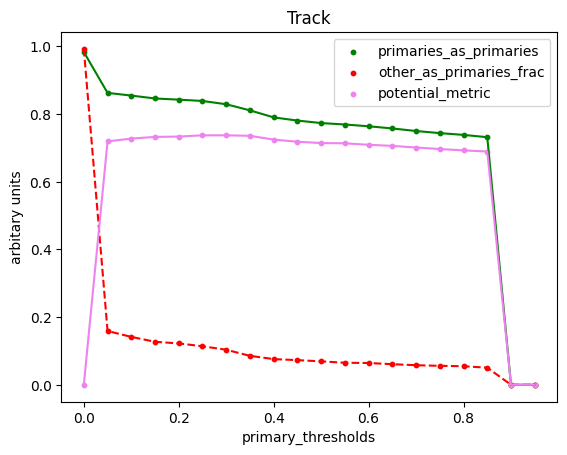

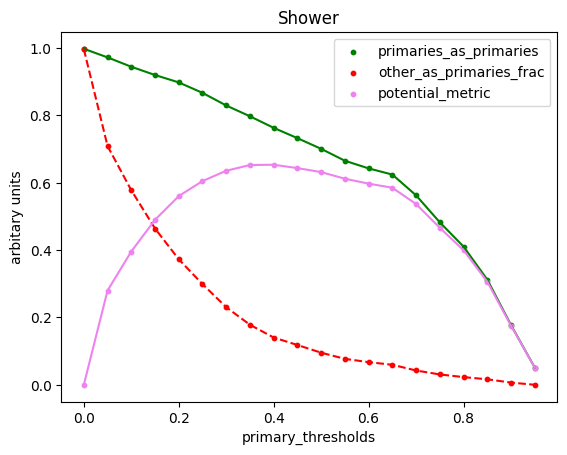

In [10]:
############################
# Draw primary plots!
############################

potential_metric = [np.array(primaries_as_primaries_frac[0]) * np.array(other_as_other_frac[0]), np.array(primaries_as_primaries_frac[1]) * np.array(other_as_other_frac[1])]


for i in [0, 1] :
#     plt.clf()
#     plt.scatter(primary_thresholds, primary_efficiency[i], color='red', label='efficiency', s=10)
#     plt.plot(primary_thresholds, primary_efficiency[i], color='red')
#     plt.scatter(primary_thresholds, primary_purity[i], color='green', label='purity', s=10)
#     plt.plot(primary_thresholds, primary_purity[i], color='green')
#     plt.scatter(primary_thresholds, primary_metric[i], color='violet', label='efficiency*purity', s=10)
#     plt.plot(primary_thresholds, primary_metric[i], color='violet')

#     plt.title('Track' if i == 0 else 'Shower')
#     plt.xlabel('primary_thresholds')
#     plt.ylabel('arbitary units')
#     plt.legend()
#     plt.show()

    ############################

    plt.clf()
    plt.scatter(primary_thresholds, primaries_as_primaries_frac[i], color='green', label='primaries_as_primaries', s=10)
    plt.plot(primary_thresholds, primaries_as_primaries_frac[i], color='green')
    #plt.scatter(primary_thresholds, primaries_as_other_frac[i], color='red', label='primaries_as_other_frac', s=10)
    #plt.plot(primary_thresholds, primaries_as_other_frac[i], color='red')
    #plt.scatter(primary_thresholds, other_as_other_frac[i], color='green', label='other_as_other_frac', s=10)
    #plt.plot(primary_thresholds, other_as_other_frac[i], color='green', linestyle='dashed')
    plt.scatter(primary_thresholds, other_as_primaries_frac[i], color='red', label='other_as_primaries_frac', s=10)
    plt.plot(primary_thresholds, other_as_primaries_frac[i], color='red', linestyle='dashed')


    plt.scatter(primary_thresholds, potential_metric[i], color='violet', label='potential_metric', s=10)
    plt.plot(primary_thresholds, potential_metric[i], color='violet')

    plt.title('Track' if i == 0 else 'Shower')
    plt.xlabel('primary_thresholds')
    plt.ylabel('arbitary units')
    plt.legend()
    plt.show()

In [11]:
#######################################
# Define optimal primary threshold
#######################################

PRIMARY_THRESHOLD_TRACK = 0.80
PRIMARY_THRESHOLD_SHOWER = 0.45

In [12]:
##################################################
# Build the primary tier with optimised threshold!
##################################################

new_gen = []
new_parentPFPIndex = []
new_pfpOrientation = []

primaries = []

for iEvent in range(nEntries) :
    
    childToParentDict = childToParentDict_main[iEvent]

    # Get data for event
    particle_mask = np.array(particleMask_in[iEvent])
    primary_link_mask = np.array(primaryLinkMask_in[iEvent])
    higher_link_mask = np.array(higherLinkMask_in[iEvent])    
    
    nSpacepoints = np.array(nSpacepoints_in[iEvent], dtype='int')[particle_mask]
    trackShowerScore = np.array(trackShowerScore_in[iEvent])[particle_mask]
    trueVisibleGeneration = np.array(trueVisibleGeneration_in[iEvent], dtype='int')[particle_mask]
    primaryPFPIndex = np.array(primaryPFPIndex_in[iEvent], dtype='int')[primary_link_mask]
    primaryScores = np.array(primaryTotNetworkPred_in[iEvent])[primary_link_mask]
    primaryPredOrientation = np.array(primaryPredOrientation_in[iEvent], dtype='int')[primary_link_mask]
    
    higherTierChildIndex = np.array(childPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
    higherTierParentIndex = np.array(parentPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
    higherTierScores = np.array(higherTotNetworkPred_in[iEvent])[higher_link_mask]        
        
    nParticles = np.count_nonzero(particle_mask)
    
    this_parentPFPIndex = [BOGUS_INT] * nParticles
    this_gen = [BOGUS_INT] * nParticles
    this_pfpOrientation = [BOGUS_INT] * nParticles
    
    this_primaries = []
    
    for iParticle in range(nParticles) :
        
        if (nSpacepoints[iParticle] == 0) : 
            continue
            
#         if (trueVisibleGeneration[iParticle] == 2) :
#             this_primaries.append(iParticle)
#             this_gen[iParticle] = 2
#             this_parentPFPIndex[iParticle] = -1
                
        
        isTrack = trackShowerScore[iParticle] > 0.5
            
        primaryNetworkArrayIndex = np.where(primaryPFPIndex == iParticle)
        
        higherTierScore = 0.0

        if (len(childToParentDict[iParticle]) != 0) :
            higherTierLinkIndex = np.where(np.logical_and(higherTierChildIndex == iParticle, higherTierParentIndex == childToParentDict[iParticle][0]))[0]
            higherTierScore = 0.0 if len(higherTierLinkIndex) == 0 else higherTierScores[higherTierLinkIndex[0]]
        
        if (primaryNetworkArrayIndex[0].shape[0] == 0) :
            continue
        
        if ((higherTierScore < 1.0) and ((isTrack and primaryScores[primaryNetworkArrayIndex[0][0]] > PRIMARY_THRESHOLD_TRACK and primaryPredOrientation[primaryNetworkArrayIndex[0][0]] == 1) or
            ((not isTrack) and primaryScores[primaryNetworkArrayIndex[0][0]] > PRIMARY_THRESHOLD_SHOWER))) :
            this_primaries.append(iParticle)
            this_gen[iParticle] = 2
            this_parentPFPIndex[iParticle] = -1
            this_pfpOrientation[iParticle] = 1 #primaryPredOrientation[primaryNetworkArrayIndex[0][0]]
    
    new_gen.append(this_gen)
    new_parentPFPIndex.append(this_parentPFPIndex)
    new_pfpOrientation.append(this_pfpOrientation)
    primaries.append(this_primaries)

In [13]:
for iEvent in range(nEntries) :
    frog = np.array(new_pfpOrientation[iEvent])

In [14]:
#Metrics.calculateMetrics_primaryLinkOrientation(nEntries, particleMask_in, primaryLinkMask_in, primaryPFPIndex_in, primaryIsPredOrientationCorrect_in, new_gen)

# This will be 100% by design
Metrics.calculateMetrics_LinkOrientationCorrectness(nEntries, particleMask_in, trackShowerScore_in, particleCorrectOrientation_in, trueVisibleGeneration_in, new_pfpOrientation, new_gen, 2)


##########################
# Metrics for child gen: 2
##########################
n_assigned: 3796
n_correct: 3796
correctness of TRUE links: 100.0


In [15]:
########################################
# Make copies to save...
########################################

new_gen_pass1 = copy.deepcopy(new_gen)
new_parentPFPIndex_pass1 = copy.deepcopy(new_parentPFPIndex)

In [16]:
############################
# Tune higher tiers
############################

############################
# first assign to best!!!
############################

higher_thresholds = []

# [track, shower]
secondary_correct_parent_frac = [[], []]
secondary_no_parent_frac = [[], []]
secondary_incorrect_parent_frac = [[], []]

tertiary_correct_parent_frac = [[], []]
tertiary_no_parent_frac = [[], []]
tertiary_incorrect_parent_frac = [[], []]

higher_correct_parent_frac = [[], []]
higher_no_parent_frac = [[], []]
higher_incorrect_parent_frac = [[], []]

############################
# Loop through thresholds
############################
for higher_threshold in range(0,20) :
    
    higher_threshold /= float(20)
    #print('---------------------------------------------')
    #print('higher_threshold:', higher_threshold)
    #print('')
    
    higher_thresholds.append(higher_threshold)

    n_secondary = [0, 0]
    secondary_correct_parent = [0, 0]
    secondary_no_parent = [0, 0]
    secondary_incorrect_parent = [0, 0]

    n_tertiary = [0, 0]
    tertiary_correct_parent = [0, 0]
    tertiary_no_parent = [0, 0]
    tertiary_incorrect_parent = [0, 0]
    
    n_higher = [0, 0]
    higher_correct_parent = [0, 0]
    higher_no_parent = [0, 0]
    higher_incorrect_parent = [0, 0]

    ############################
    # Loop through events
    ############################
    
    for iEvent in range(nEntries) :

        this_particle_tiers = [[]]
        this_particle_tiers[0] = primaries[iEvent]
        parentToChildDict = parentToChildDict_main[iEvent]

         # we have to make copies as we're going to want to fill these lists with the final result
        this_parentPFPIndex = new_parentPFPIndex[iEvent].copy()
        this_gen = new_gen[iEvent].copy()
        this_pfpOrientation = new_pfpOrientation[iEvent].copy()
        
        # Get data for the event
        particle_mask = np.array(particleMask_in[iEvent])     
        higher_link_mask = np.array(higherLinkMask_in[iEvent])        
        
        nSpacepoints = np.array(nSpacepoints_in[iEvent], dtype='int')[particle_mask]
        trackShowerScore = np.array(trackShowerScore_in[iEvent])[particle_mask]
        trueVisibleGeneration = np.array(trueVisibleGeneration_in[iEvent], dtype='int')[particle_mask]
        trueVisibleParentPFPIndex = np.array(trueVisibleParentPFPIndex_in[iEvent], dtype='int')[particle_mask]
        
        higherTierChildIndex = np.array(childPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
        higherTierParentIndex = np.array(parentPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
        higherTierScores = np.array(higherTotNetworkPred_in[iEvent])[higher_link_mask]
        parentPredOrientation = np.array(parentPredOrientation_in[iEvent], dtype='int')[higher_link_mask]
        childPredOrientation = np.array(childPredOrientation_in[iEvent], dtype='int')[higher_link_mask]
        
        ############################
        # Build hierarchy
        ############################      
        # Fill each tier at a time
        while (len(this_particle_tiers[-1]) != 0) :
            
            tier = []
            
            # Add in highest?
            for iParent in this_particle_tiers[-1]:
                for iChild in parentToChildDict[iParent] :
                    
                    # If the child has already been assigned a parent
                    if (this_gen[iChild] != BOGUS_INT) :
                        continue
                        
                    linkIndex = np.where(np.logical_and(higherTierChildIndex == iChild, higherTierParentIndex == iParent))[0]
                        
                    if (len(linkIndex) == 0) :
                        continue
                        
                    linkIndex = linkIndex[0]
                    
                    # Does the parent orientation match?
                    if (parentPredOrientation[linkIndex] != this_pfpOrientation[iParent]) :
                        continue                    
                    
                    isTrack = trackShowerScore[iChild] > 0.5
                    
                    if (higherTierScores[linkIndex] < higher_threshold) : 
                        continue
                                            
                
#                     # Secondary
#                     if ((len(this_particle_tiers) == 1) and isTrack and (higherTierScores[linkIndex] < 0.8)) :
#                         continue

#                     if ((len(this_particle_tiers) == 1) and (not isTrack) and (higherTierScores[linkIndex] < 0.8)) :
#                         continue                     

#                     if ((len(this_particle_tiers) != 1) and (higherTierScores[linkIndex] < higher_threshold)) : 
#                         continue
                        
                    this_parentPFPIndex[iChild] = iParent
                    this_gen[iChild] = len(this_particle_tiers) + 2
                    this_pfpOrientation[iChild] = childPredOrientation[linkIndex] 
                    tier.append(iChild)

            this_particle_tiers.append(tier)
            
        ############################
        # Turn into numpy arrays
        ############################  
        this_parentPFPIndex = np.array(this_parentPFPIndex)
        this_gen = np.array(this_gen)

        for trackShowerIndex in [0, 1] :
            ignore_mask = np.logical_or(nSpacepoints == 0, trueVisibleGeneration == -999)
            trackShower_mask = (trackShowerScore > 0.5) if trackShowerIndex == 0 else np.logical_not(trackShowerScore > 0.5)

            #########################
            # Get tier masks
            #########################
            true_primary_mask = np.logical_and(np.logical_and(np.logical_not(ignore_mask), trackShower_mask), trueVisibleGeneration == 2)
            true_secondary_mask = np.logical_and(np.logical_and(np.logical_not(ignore_mask), trackShower_mask), trueVisibleGeneration == 3)
            true_tertiary_mask = np.logical_and(np.logical_and(np.logical_not(ignore_mask), trackShower_mask), trueVisibleGeneration == 4)
            true_higher_mask = np.logical_and(np.logical_and(np.logical_not(ignore_mask), trackShower_mask), 
                                              np.logical_not(np.logical_or(true_primary_mask, np.logical_or(true_secondary_mask, true_tertiary_mask))))

            ############################
            # Counts
            ############################ 
            # Secondary
            n_secondary[trackShowerIndex] += np.count_nonzero(true_secondary_mask)
            secondary_correct_parent[trackShowerIndex] += np.count_nonzero(np.logical_and(trueVisibleParentPFPIndex[true_secondary_mask] == this_parentPFPIndex[true_secondary_mask], 
                                                                                          this_gen[true_secondary_mask] == 3))
#             secondary_correct_parent[trackShowerIndex] += np.count_nonzero(trueVisibleParentPFPIndex[true_secondary_mask] == this_parentPFPIndex[true_secondary_mask])
            secondary_no_parent[trackShowerIndex] += np.count_nonzero(this_gen[true_secondary_mask] == BOGUS_INT)            
            secondary_incorrect_parent[trackShowerIndex] += np.count_nonzero(np.logical_not(np.logical_or(this_parentPFPIndex[true_secondary_mask] == trueVisibleParentPFPIndex[true_secondary_mask], \
                                                                                                         np.logical_or(this_gen[true_secondary_mask] == 2, \
                                                                                                                       this_gen[true_secondary_mask] == BOGUS_INT))))
            # Tertiary
            n_tertiary[trackShowerIndex] += np.count_nonzero(true_tertiary_mask)
            tertiary_correct_parent[trackShowerIndex] += np.count_nonzero(np.logical_and(trueVisibleParentPFPIndex[true_tertiary_mask] == this_parentPFPIndex[true_tertiary_mask], 
                                                                                         this_gen[true_tertiary_mask] == 4))
#             tertiary_correct_parent[trackShowerIndex] += np.count_nonzero(trueVisibleParentPFPIndex[true_tertiary_mask] == this_parentPFPIndex[true_tertiary_mask])            
            tertiary_no_parent[trackShowerIndex] += np.count_nonzero(this_gen[true_tertiary_mask] == BOGUS_INT)
            tertiary_incorrect_parent[trackShowerIndex] += np.count_nonzero(np.logical_not(np.logical_or(this_parentPFPIndex[true_tertiary_mask] == trueVisibleParentPFPIndex[true_tertiary_mask], \
                                                                                                         np.logical_or(this_gen[true_tertiary_mask] == 2, \
                                                                                                                       this_gen[true_tertiary_mask] == BOGUS_INT))))

            n_higher[trackShowerIndex] += np.count_nonzero(true_higher_mask)
            higher_correct_parent[trackShowerIndex] += np.count_nonzero(trueVisibleParentPFPIndex[true_higher_mask] == this_parentPFPIndex[true_higher_mask])
            higher_no_parent[trackShowerIndex] += np.count_nonzero(this_gen[true_higher_mask] == BOGUS_INT)
            higher_incorrect_parent[trackShowerIndex] += np.count_nonzero(np.logical_not(np.logical_or(this_parentPFPIndex[true_higher_mask] == trueVisibleParentPFPIndex[true_higher_mask], \
                                                                                                         np.logical_or(this_gen[true_higher_mask] == 2, \
                                                                                                                       this_gen[true_higher_mask] == BOGUS_INT))))
        
    #####################################
    # Calculate metrics for threshold
    #####################################    
    for trackShowerIndex in [0, 1] :
        
        secondary_correct_parent_frac[trackShowerIndex].append(0 if n_secondary[trackShowerIndex] == 0 else float(secondary_correct_parent[trackShowerIndex])/float(n_secondary[trackShowerIndex]))
        secondary_no_parent_frac[trackShowerIndex].append(0 if n_secondary[trackShowerIndex] == 0 else float(secondary_no_parent[trackShowerIndex])/float(n_secondary[trackShowerIndex]))
        secondary_incorrect_parent_frac[trackShowerIndex].append(0 if n_secondary[trackShowerIndex] == 0 else float(secondary_incorrect_parent[trackShowerIndex])/float(n_secondary[trackShowerIndex]))

        tertiary_correct_parent_frac[trackShowerIndex].append(0 if n_tertiary[trackShowerIndex] == 0 else float(tertiary_correct_parent[trackShowerIndex])/float(n_tertiary[trackShowerIndex]))
        tertiary_no_parent_frac[trackShowerIndex].append(0 if n_tertiary[trackShowerIndex] == 0 else float(tertiary_no_parent[trackShowerIndex])/float(n_tertiary[trackShowerIndex]))
        tertiary_incorrect_parent_frac[trackShowerIndex].append(0 if n_tertiary[trackShowerIndex] == 0 else float(tertiary_incorrect_parent[trackShowerIndex])/float(n_tertiary[trackShowerIndex]))

        higher_correct_parent_frac[trackShowerIndex].append(0 if n_higher[trackShowerIndex] == 0 else float(higher_correct_parent[trackShowerIndex])/float(n_higher[trackShowerIndex]))
        higher_no_parent_frac[trackShowerIndex].append(0 if n_higher[trackShowerIndex] == 0 else float(higher_no_parent[trackShowerIndex])/float(n_higher[trackShowerIndex]))
        higher_incorrect_parent_frac[trackShowerIndex].append(0 if n_higher[trackShowerIndex] == 0 else float(higher_incorrect_parent[trackShowerIndex])/float(n_higher[trackShowerIndex]))

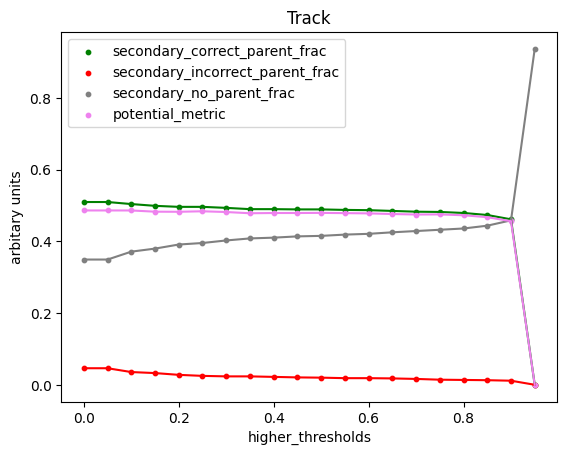

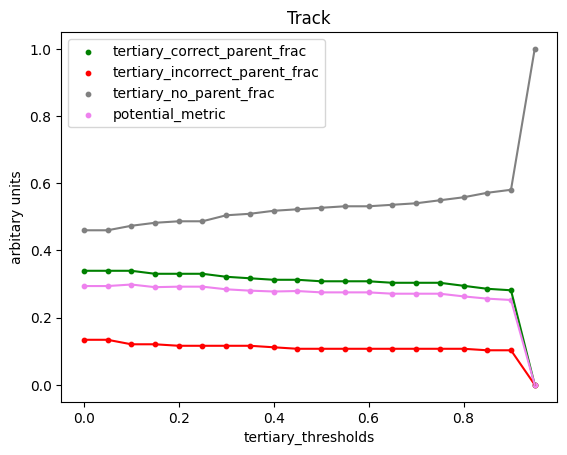

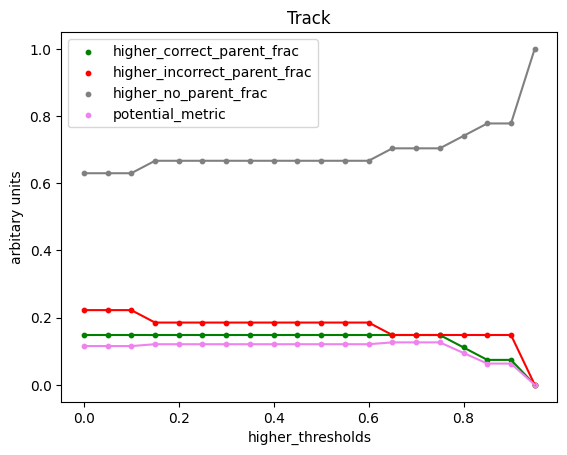

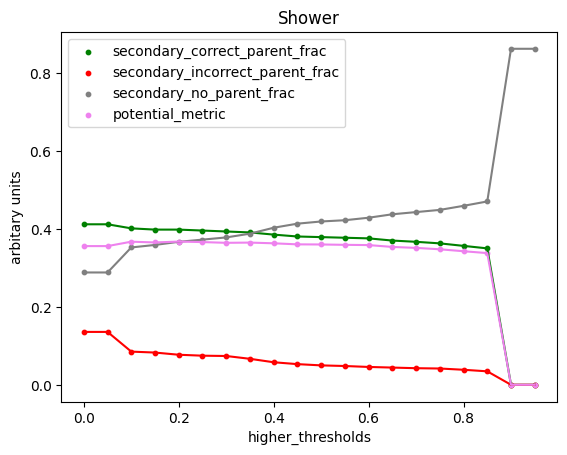

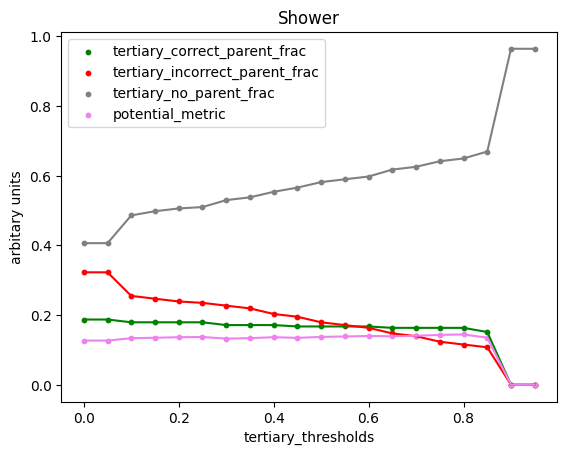

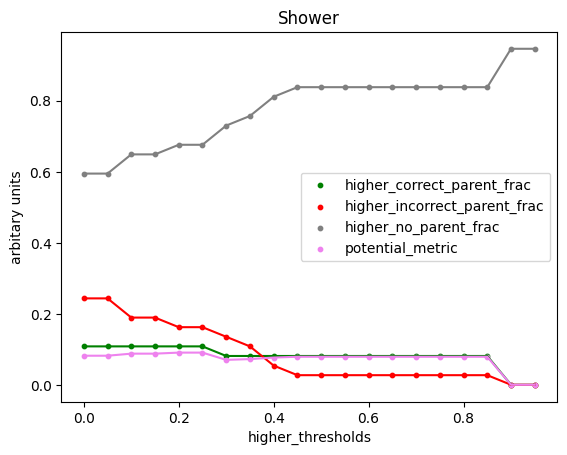

In [17]:
############################
# Draw later tier plots!
############################

potential_secondary_metric = [np.array(secondary_correct_parent_frac[0]) * (1 - np.array(secondary_incorrect_parent_frac[0])), np.array(secondary_correct_parent_frac[1]) * (1 - np.array(secondary_incorrect_parent_frac[1]))]
potential_tertiary_metric = [np.array(tertiary_correct_parent_frac[0]) * (1 - np.array(tertiary_incorrect_parent_frac[0])), np.array(tertiary_correct_parent_frac[1]) * (1 - np.array(tertiary_incorrect_parent_frac[1]))]
potential_higher_metric = [np.array(higher_correct_parent_frac[0]) * (1 - np.array(higher_incorrect_parent_frac[0])), np.array(higher_correct_parent_frac[1]) * (1 - np.array(higher_incorrect_parent_frac[1]))]

############################
# Higher tier plots!
############################
for i in [0, 1] :
    plt.clf()
    plt.scatter(higher_thresholds, secondary_correct_parent_frac[i], color='green', label='secondary_correct_parent_frac', s=10)
    plt.plot(higher_thresholds, secondary_correct_parent_frac[i], color='green')

    plt.scatter(higher_thresholds, secondary_incorrect_parent_frac[i], color='red', label='secondary_incorrect_parent_frac', s=10)
    plt.plot(higher_thresholds, secondary_incorrect_parent_frac[i], color='red')

    plt.scatter(higher_thresholds, secondary_no_parent_frac[i], color='gray', label='secondary_no_parent_frac', s=10)
    plt.plot(higher_thresholds, secondary_no_parent_frac[i], color='gray')

    plt.scatter(higher_thresholds, potential_secondary_metric[i], color='violet', label='potential_metric', s=10)
    plt.plot(higher_thresholds, potential_secondary_metric[i], color='violet')

    plt.title('Track' if i == 0 else 'Shower')
    plt.xlabel('higher_thresholds')
    plt.ylabel('arbitary units')
    plt.legend()
    plt.show()

    ############################

    plt.clf()
    plt.scatter(higher_thresholds, tertiary_correct_parent_frac[i], color='green', label='tertiary_correct_parent_frac', s=10)
    plt.plot(higher_thresholds, tertiary_correct_parent_frac[i], color='green')

    plt.scatter(higher_thresholds, tertiary_incorrect_parent_frac[i], color='red', label='tertiary_incorrect_parent_frac', s=10)
    plt.plot(higher_thresholds, tertiary_incorrect_parent_frac[i], color='red')

    plt.scatter(higher_thresholds, tertiary_no_parent_frac[i], color='gray', label='tertiary_no_parent_frac', s=10)
    plt.plot(higher_thresholds, tertiary_no_parent_frac[i], color='gray')

    plt.scatter(higher_thresholds, potential_tertiary_metric[i], color='violet', label='potential_metric', s=10)
    plt.plot(higher_thresholds, potential_tertiary_metric[i], color='violet')

    plt.title('Track' if i == 0 else 'Shower')
    plt.xlabel('tertiary_thresholds')
    plt.ylabel('arbitary units')
    plt.legend()
    plt.show()

    ############################

    plt.clf()
    plt.scatter(higher_thresholds, higher_correct_parent_frac[i], color='green', label='higher_correct_parent_frac', s=10)
    plt.plot(higher_thresholds, higher_correct_parent_frac[i], color='green')

    plt.scatter(higher_thresholds, higher_incorrect_parent_frac[i], color='red', label='higher_incorrect_parent_frac', s=10)
    plt.plot(higher_thresholds, higher_incorrect_parent_frac[i], color='red')

    plt.scatter(higher_thresholds, higher_no_parent_frac[i], color='gray', label='higher_no_parent_frac', s=10)
    plt.plot(higher_thresholds, higher_no_parent_frac[i], color='gray')

    plt.scatter(higher_thresholds, potential_higher_metric[i], color='violet', label='potential_metric', s=10)
    plt.plot(higher_thresholds, potential_higher_metric[i], color='violet')

    plt.title('Track' if i == 0 else 'Shower')
    plt.xlabel('higher_thresholds')
    plt.ylabel('arbitary units')
    plt.legend()
    plt.show()

In [18]:
#######################################
# Define optimal higher threshold
#######################################

SECONDARY_THRESHOLD_TRACK_PASS1 = 0.80
SECONDARY_THRESHOLD_SHOWER_PASS1 = 0.80

HIGHER_THRESHOLD_TRACK_PASS1 = 0.80
HIGHER_THRESHOLD_SHOWER_PASS1 = 0.80

In [19]:
##################################################
# Build the higher tier with optimised threshold!
##################################################

for iEvent in range(nEntries) :

    this_particle_tiers = [[]]
    this_particle_tiers[0] = primaries[iEvent]

    # In this case we do not want to make a copy
    this_parentPFPIndex = new_parentPFPIndex[iEvent] 
    this_gen = new_gen[iEvent] 
    this_pfpOrientation = new_pfpOrientation[iEvent]
    parentToChildDict = parentToChildDict_main[iEvent]
    particlePredictedOrientation = particlePredictedOrientation_main[iEvent]
    
    # Get data for the event
    particle_mask = np.array(particleMask_in[iEvent])
    higher_link_mask = np.array(higherLinkMask_in[iEvent])

    nSpacepoints = np.array(nSpacepoints_in[iEvent], dtype='int')[particle_mask]
    trackShowerScore = np.array(trackShowerScore_in[iEvent])[particle_mask]
    trueTrackID = np.array(trueTrackID_in[iEvent], dtype='int')[particle_mask]
    trueVisibleGeneration = np.array(trueVisibleGeneration_in[iEvent], dtype='int')[particle_mask]
    trueVisibleParentPFPIndex = np.array(trueVisibleParentPFPIndex_in[iEvent], dtype='int')[particle_mask]

    higherTierChildIndex = np.array(childPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
    higherTierParentIndex = np.array(parentPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
    higherTierScores = np.array(higherTotNetworkPred_in[iEvent])[higher_link_mask]
    parentPredOrientation = np.array(parentPredOrientation_in[iEvent], dtype='int')[higher_link_mask]
    childPredOrientation = np.array(childPredOrientation_in[iEvent], dtype='int')[higher_link_mask]        

    ############################
    # Build hierarchy
    ############################    
    # Fill each tier at a time
    while (len(this_particle_tiers[-1]) != 0) :

        tier = []

        # Loop over particles in last built tier
        for iParent in this_particle_tiers[-1]:
            for iChild in parentToChildDict[iParent] :

                # If the child has already been assigned a parent
                if (this_gen[iChild] != BOGUS_INT) :
                    continue

                linkIndex = np.where(np.logical_and(higherTierChildIndex == iChild, higherTierParentIndex == iParent))[0][0] 
                
                # Does the parent orientation match?
#                 if (parentPredOrientation[linkIndex] != this_pfpOrientation[iParent]) :
#                     continue         
                
                isTrack = trackShowerScore[iChild] > 0.5
                    
                 # Secondary
                if ((len(this_particle_tiers) == 1) and isTrack and (higherTierScores[linkIndex] < SECONDARY_THRESHOLD_TRACK_PASS1)) :
                    continue
                
                if ((len(this_particle_tiers) == 1) and (not isTrack) and (higherTierScores[linkIndex] < SECONDARY_THRESHOLD_SHOWER_PASS1)) :
                    continue

                # Higher
                if ((len(this_particle_tiers) != 1) and (isTrack) and (higherTierScores[linkIndex] < HIGHER_THRESHOLD_TRACK_PASS1)) : 
                    continue

                if ((len(this_particle_tiers) != 1) and (not isTrack) and (higherTierScores[linkIndex] < HIGHER_THRESHOLD_SHOWER_PASS1)) : 
                    continue

                this_parentPFPIndex[iChild] = iParent
                this_gen[iChild] = len(this_particle_tiers) + 2
                this_pfpOrientation[iChild] = childPredOrientation[linkIndex] #particlePredictedOrientation[iChild] if isTrack else -1
                tier.append(iChild)

        # Tier complete, add into hierarchy
        this_particle_tiers.append(tier)


In [20]:
for iEvent in range(nEntries) :
    frog = np.array(new_pfpOrientation[iEvent])

In [21]:
########################################
# Make copies to save...
########################################
new_gen_pass2 = copy.deepcopy(new_gen)
new_parentPFPIndex_pass2 = copy.deepcopy(new_parentPFPIndex)

In [22]:
# This will be 100% by design
Metrics.calculateMetrics_LinkOrientationCorrectness(nEntries, particleMask_in, trackShowerScore_in, particleCorrectOrientation_in, trueVisibleGeneration_in, new_pfpOrientation, new_gen, 3)

##########################
# Metrics for child gen: 3
##########################
n_assigned: 741
n_correct: 741
correctness of TRUE links: 100.0


In [23]:
# Metrics.calculateMetrics_higherLinkOrientation(nEntries, particleMask_in, higherLinkMask_in, trackShowerScore_in, parentPFPIndex_in, childPFPIndex_in, higherIsPredOrientationCorrect_in, new_gen, new_parentPFPIndex, 3)
# Metrics.calculateMetrics_higherLinkOrientation(nEntries, particleMask_in, higherLinkMask_in, trackShowerScore_in, parentPFPIndex_in, childPFPIndex_in, higherIsPredOrientationCorrect_in, new_gen, new_parentPFPIndex, 4)
# Metrics.calculateMetrics_higherLinkOrientation(nEntries, particleMask_in, higherLinkMask_in, trackShowerScore_in, parentPFPIndex_in, childPFPIndex_in, higherIsPredOrientationCorrect_in, new_gen, new_parentPFPIndex, 5)

In [24]:
################################################
# See if I can add more to the primaries?
################################################

primary_thresholds = []

# [track, shower]
primary_efficiency = [[],[]]
primary_purity = [[], []]
primary_metric = [[], []]
primaries_as_primaries_frac = [[], []]
primaries_as_other_frac = [[], []]
other_as_primaries_frac = [[], []]
other_as_other_frac = [[], []]

############################
# Loop through thresholds
############################
for primary_threshold in range(0,20) :
    
    primary_threshold /= float(20)
    #print('---------------------------------------------')
    #print('primary_threshold:', primary_threshold)
    #print('')
    
    primary_thresholds.append(primary_threshold)
    
    n_true_primaries = [0, 0]
    n_primaries_as_primaries = [0, 0]
    n_primaries_as_other = [0, 0]
    n_primaries_as_nothing = [0, 0]
    n_true_other = [0, 0]
    n_other_as_primaries = [0, 0]
    n_other_as_other = [0, 0]
    n_other_as_nothing = [0, 0]
    
    ############################
    # Loop through events
    ############################
    for iEvent in range(nEntries) :
        
        # we have to make copies as we're going to want to fill these lists with the final result
        this_gen = new_gen[iEvent].copy()
        childToParentDict = childToParentDict_main[iEvent]

        # Get data for event
        particle_mask = np.array(particleMask_in[iEvent])
        higher_link_mask = np.array(higherLinkMask_in[iEvent])
        
        nSpacepoints = np.array(nSpacepoints_in[iEvent], dtype='int')[particle_mask] #
        trackShowerScore = np.array(trackShowerScore_in[iEvent])[particle_mask] #
        trueVisibleGeneration = np.array(trueVisibleGeneration_in[iEvent], dtype='int')[particle_mask]
        
        higherTierChildIndex = np.array(childPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
        higherTierParentIndex = np.array(parentPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
        higherTierScores = np.array(higherTotNetworkPred_in[iEvent])[higher_link_mask]
        
        nParticles = np.count_nonzero(particle_mask)        
        
        for iParticle in range(nParticles) :
            
            if (nSpacepoints[iParticle] == 0) :
                continue
            
            trackShowerIndex = (0 if (trackShowerScore[iParticle] > 0.5) else 1)

            if (trueVisibleGeneration[iParticle] == 2) :
                n_true_primaries[trackShowerIndex] += 1
                
                if (this_gen[iParticle] != BOGUS_INT) :
                    continue
                else :
                    if (len(childToParentDict[iParticle]) == 0) :
                        n_primaries_as_primaries[trackShowerIndex] += 1
                        continue     
                        
                    linkIndex = np.where(np.logical_and(higherTierChildIndex == iParticle, higherTierParentIndex == childToParentDict[iParticle][0]))[0]

                    if (higherTierScores[linkIndex[0]] < primary_threshold) :
                        n_primaries_as_primaries[trackShowerIndex] += 1
                    else :
                        n_primaries_as_other[trackShowerIndex] += 1
            else :
                n_true_other[trackShowerIndex] += 1
                
                if (this_gen[iParticle] != BOGUS_INT) :
                    continue
                else :
                    if (len(childToParentDict[iParticle]) == 0) :
                        n_other_as_primaries[trackShowerIndex] += 1
                        continue     
                        
                    linkIndex = np.where(np.logical_and(higherTierChildIndex == iParticle, higherTierParentIndex == childToParentDict[iParticle][0]))[0]

                    if (higherTierScores[linkIndex[0]] < primary_threshold) :
                        n_other_as_primaries[trackShowerIndex] += 1
                    else :
                        n_other_as_other[trackShowerIndex] += 1
                                        
    ############################
    # Work out metrics
    ############################
    for i in [0, 1] :
        selected_primaries = n_primaries_as_primaries[i] + n_other_as_primaries[i]
        primary_efficiency[i].append(0 if n_true_primaries[i] == 0 else float(n_primaries_as_primaries[i])/float(n_true_primaries[i]))
        primary_purity[i].append(0 if selected_primaries == 0 else float(n_primaries_as_primaries[i])/float(selected_primaries))
        primary_metric[i].append(primary_efficiency[i][-1] * primary_purity[i][-1])

        primaries_as_primaries_frac[i].append(0 if n_true_primaries[i] == 0 else float(n_primaries_as_primaries[i]) / float(n_true_primaries[i]))
        primaries_as_other_frac[i].append(0 if n_true_primaries[i] == 0 else float(n_primaries_as_other[i]) / float(n_true_primaries[i]))
        other_as_primaries_frac[i].append(0 if n_true_other[i] == 0 else float(n_other_as_primaries[i]) / float(n_true_other[i]))
        other_as_other_frac[i].append(0 if n_true_other[i] == 0 else float(n_other_as_other[i]) / float(n_true_other[i]))

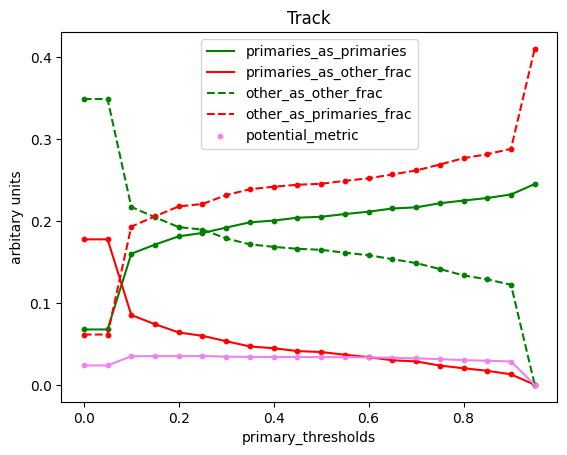

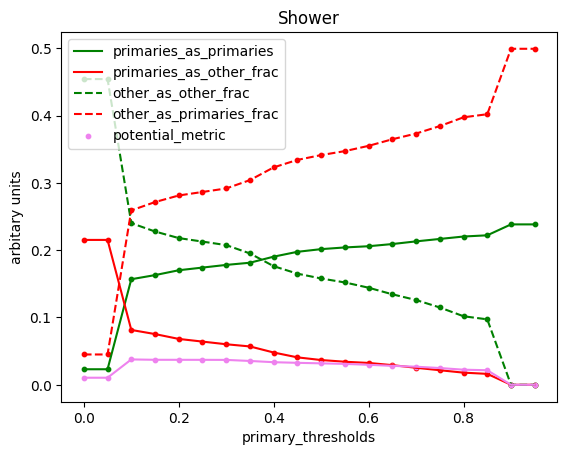

In [25]:
############################
# Draw primary plots!
############################

potential_metric = [np.array(primaries_as_primaries_frac[0]) * np.array(other_as_other_frac[0]), np.array(primaries_as_primaries_frac[1]) * np.array(other_as_other_frac[1])]


for i in [0, 1] :
#     plt.clf()
#     plt.scatter(primary_thresholds, primary_efficiency[i], color='red', label='efficiency', s=10)
#     plt.plot(primary_thresholds, primary_efficiency[i], color='red')
#     plt.scatter(primary_thresholds, primary_purity[i], color='green', label='purity', s=10)
#     plt.plot(primary_thresholds, primary_purity[i], color='green')
#     plt.scatter(primary_thresholds, primary_metric[i], color='violet', label='efficiency*purity', s=10)
#     plt.plot(primary_thresholds, primary_metric[i], color='violet')

#     plt.title('Track' if i == 0 else 'Shower')
#     plt.xlabel('primary_thresholds')
#     plt.ylabel('arbitary units')
#     plt.legend()
#     plt.show()

    ############################

    plt.clf()
    plt.scatter(primary_thresholds, primaries_as_primaries_frac[i], color='green', s=10)
    plt.plot(primary_thresholds, primaries_as_primaries_frac[i], color='green', label='primaries_as_primaries')
    plt.scatter(primary_thresholds, primaries_as_other_frac[i], color='red', s=10)
    plt.plot(primary_thresholds, primaries_as_other_frac[i], color='red', label='primaries_as_other_frac')
    plt.scatter(primary_thresholds, other_as_other_frac[i], color='green', s=10)
    plt.plot(primary_thresholds, other_as_other_frac[i], color='green', linestyle='dashed', label='other_as_other_frac')
    plt.scatter(primary_thresholds, other_as_primaries_frac[i], color='red', s=10)
    plt.plot(primary_thresholds, other_as_primaries_frac[i], color='red', linestyle='dashed', label='other_as_primaries_frac')


    plt.scatter(primary_thresholds, potential_metric[i], color='violet', label='potential_metric', s=10)
    plt.plot(primary_thresholds, potential_metric[i], color='violet')

    plt.title('Track' if i == 0 else 'Shower')
    plt.xlabel('primary_thresholds')
    plt.ylabel('arbitary units')
    plt.legend()
    plt.show()

In [26]:
PRIMARY_THRESHOLD_TRACK_PASS2 = 0.90
PRIMARY_THRESHOLD_SHOWER_PASS2 = 0.90

In [27]:
##################################################
# Build the primary tier with optimised threshold!
##################################################

# new_gen.append(this_gen)
# new_parentPFPIndex.append(this_parentPFPIndex)

for iEvent in range(nEntries) :
    
    childToParentDict = childToParentDict_main[iEvent]

    # Get data for event
    particle_mask = np.array(particleMask_in[iEvent])
    primary_link_mask = np.array(primaryLinkMask_in[iEvent])
    higher_link_mask = np.array(higherLinkMask_in[iEvent])    
    
    nSpacepoints = np.array(nSpacepoints_in[iEvent], dtype='int')[particle_mask] #
    trackShowerScore = np.array(trackShowerScore_in[iEvent])[particle_mask] #
    
    higherTierChildIndex = np.array(childPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
    higherTierParentIndex = np.array(parentPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
    higherTierScores = np.array(higherTotNetworkPred_in[iEvent])[higher_link_mask]        
        
    nParticles = np.count_nonzero(particle_mask)
    
    # We want to change these!
    this_parentPFPIndex = new_parentPFPIndex[iEvent]
    this_gen = new_gen[iEvent]
    this_pfpOrientation = new_pfpOrientation[iEvent]
    this_primaries = primaries[iEvent]
    
    for iParticle in range(nParticles) :
        
        # If it has already been set?
        if (this_gen[iParticle] != BOGUS_INT) :
            continue
        
        if (nSpacepoints[iParticle] == 0) : 
            continue

        isTrack = trackShowerScore[iParticle] > 0.5
        
        higherTierScore = 0.0

        if (len(childToParentDict[iParticle]) != 0) :
            higherTierLinkIndex = np.where(np.logical_and(higherTierChildIndex == iParticle, higherTierParentIndex == childToParentDict[iParticle][0]))[0]
            higherTierScore = 0.0 if len(higherTierLinkIndex) == 0 else higherTierScores[higherTierLinkIndex[0]]

#         print('iParticle:', iParticle)
#         print('iPArent:', childToParentDict[iParticle][0])
#         print('higherTierScore:', higherTierScore)
            
        if ((isTrack and (higherTierScore < PRIMARY_THRESHOLD_TRACK_PASS2)) or
            ((not isTrack) and (higherTierScore < PRIMARY_THRESHOLD_SHOWER_PASS2))) :
            this_primaries.append(iParticle)
            this_gen[iParticle] = 2
            this_parentPFPIndex[iParticle] = -1

In [28]:
#Metrics.calculateMetrics_primaryLinkOrientation(nEntries, particleMask_in, primaryLinkMask_in, primaryPFPIndex_in, primaryIsPredOrientationCorrect_in, new_gen)

In [29]:
for iEvent in range(nEntries) :
    frog = np.array(new_pfpOrientation[iEvent])

In [30]:
########################################
# Make copies to save...
########################################

new_gen_pass3 = copy.deepcopy(new_gen)
new_parentPFPIndex_pass3 = copy.deepcopy(new_parentPFPIndex)

In [31]:
##################################################
# Try to assign any remaining in a smart way?
##################################################

for iEvent in range(nEntries) :
    
    # Create our particle hierarchy to build
    this_particle_tiers = [[]]
    this_particle_tiers[0] = primaries[iEvent]

    # In this case we do not want to make a copy
    this_parentPFPIndex = new_parentPFPIndex[iEvent] 
    this_gen = new_gen[iEvent] 
    this_pfpOrientation = new_pfpOrientation[iEvent]
    childToParentDict = childToParentDict_main[iEvent]
    
    # Get data for the event
    particle_mask = np.array(particleMask_in[iEvent])
    nSpacepoints = np.array(nSpacepoints_in[iEvent], dtype='int')[particle_mask]
    
    
    higher_link_mask = np.array(higherLinkMask_in[iEvent])
    higherTierChildIndex = np.array(childPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
    higherTierParentIndex = np.array(parentPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
    parentPredOrientation = np.array(parentPredOrientation_in[iEvent], dtype='int')[higher_link_mask]
    childPredOrientation = np.array(childPredOrientation_in[iEvent], dtype='int')[higher_link_mask]

    ############################
    # Build hierarchy
    ############################    
    while (len(this_particle_tiers[-1]) != 0) :

        tier = []

        # Loop over our children to see if we can assign them...
        for iParticle in range(np.count_nonzero(particle_mask)) : 
            
            if (nSpacepoints[iParticle] == 0) :
                continue

            # If the child has already been assigned a parent
            if (this_gen[iParticle] != BOGUS_INT) :
                if (len(np.where(this_particle_tiers[-1] == this_parentPFPIndex[iParticle])[0]) != 0) :
                    tier.append(iParticle)
            else :
                if (len(childToParentDict[iParticle]) != 0) :                    
                    iParent = childToParentDict[iParticle][0]                    
                    higherTierLinkIndex = np.where(np.logical_and(higherTierChildIndex == iParticle, higherTierParentIndex == iParent))[0]

                    #Does the parent orientation match?
#                     if (parentPredOrientation[higherTierLinkIndex] != this_pfpOrientation[iParent]) :
#                         continue         
                    
                    if (len(np.where(this_particle_tiers[-1] == childToParentDict[iParticle][0])[0]) != 0) :
                        this_parentPFPIndex[iParticle] = childToParentDict[iParticle][0]
                        this_gen[iParticle] = len(this_particle_tiers) + 2
                        this_pfpOrientation[iParticle] = childPredOrientation[higherTierLinkIndex[0]]
                        tier.append(iParticle)

        # Tier complete, add into hierarchy
        this_particle_tiers.append(tier)

In [32]:
#Metrics.calculateMetrics_higherLinkOrientation(nEntries, particleMask_in, higherLinkMask_in, trackShowerScore_in, parentPFPIndex_in, childPFPIndex_in, higherIsPredOrientationCorrect_in, new_gen, new_parentPFPIndex, 3)
#Metrics.calculateMetrics_higherLinkOrientation(nEntries, particleMask_in, higherLinkMask_in, trackShowerScore_in, parentPFPIndex_in, childPFPIndex_in, higherIsPredOrientationCorrect_in, new_gen, new_parentPFPIndex, 4)
#Metrics.calculateMetrics_higherLinkOrientation(nEntries, particleMask_in, higherLinkMask_in, trackShowerScore_in, parentPFPIndex_in, childPFPIndex_in, higherIsPredOrientationCorrect_in, new_gen, new_parentPFPIndex, 5)

In [33]:
for iEvent in range(nEntries) :
    frog = np.array(new_pfpOrientation[iEvent])

In [34]:
########################################
# Make copies to save...
########################################

new_gen_pass4 = copy.deepcopy(new_gen)
new_parentPFPIndex_pass4 = copy.deepcopy(new_parentPFPIndex)

In [35]:
######################################
# Say that any remaining are primaries
###################################### 

for iEvent in range(nEntries) : 

    this_parentPFPIndex= new_parentPFPIndex[iEvent] # Will not make a copy (will be by reference)
    this_gen = new_gen[iEvent] # Will not make a copy (will be by reference)
    
    for iParticle in range(len(this_gen)) :
            
        if (this_gen[iParticle] == BOGUS_INT) :
            this_parentPFPIndex[iParticle] = -1
            this_gen[iParticle] = 2


In [36]:
#Metrics.calculateMetrics_primaryLinkOrientation(nEntries, particleMask_in, primaryLinkMask_in, primaryPFPIndex_in, primaryIsPredOrientationCorrect_in, new_gen)

In [37]:
########################################
# Make copies to save...
########################################

new_gen_pass5 = copy.deepcopy(new_gen)
new_parentPFPIndex_pass5 = copy.deepcopy(new_parentPFPIndex)

In [38]:
########################################
# Try to do a little refinement 
########################################

for iEvent in range(nEntries) : 

    this_parentPFPIndex = new_parentPFPIndex[iEvent]
    this_gen = new_gen[iEvent]
    this_pfpOrientation = new_pfpOrientation[iEvent]
    
    # Get data for the event
    particle_mask = np.array(particleMask_in[iEvent])
    nSpacepoints = np.array(nSpacepoints_in[iEvent], dtype='int')[particle_mask]
    trackShowerScore = np.array(trackShowerScore_in[iEvent])[particle_mask]
    trueVisibleGeneration = np.array(trueVisibleGeneration_in[iEvent], dtype='int')[particle_mask]
    trueVisibleParentPFPIndex = np.array(trueVisibleParentPFPIndex_in[iEvent], dtype='int')[particle_mask]  
    
    higher_link_mask = np.array(higherLinkMask_in[iEvent])
    higherTierChildIndex = np.array(childPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
    higherTierParentIndex = np.array(parentPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
    higherTierScores = np.array(higherTotNetworkPred_in[iEvent])[higher_link_mask]        
    parentPredOrientation = np.array(parentPredOrientation_in[iEvent], dtype='int')[higher_link_mask]
    
    run = run_in[iEvent]
    event = event_in[iEvent]
    trackShowerScore = np.array(trackShowerScore_in[iEvent])[particle_mask]
    
    # Get equivalent iEvent for SAM data
    iEvent_SAM = np.where(np.logical_and(run_SAM_in == run, event_SAM_in == event))[0]
    
    if (iEvent_SAM.shape[0] == 0):
        print('EVERYTHING IS SAD AND BROKEN')
        raise
    
    # Get equivalent SAM data
    iEvent_SAM = iEvent_SAM[0]    
    
    recoNuVertexX_SAM = recoNuVertexX_SAM_in[iEvent_SAM]
    recoNuVertexY_SAM = recoNuVertexY_SAM_in[iEvent_SAM]
    recoNuVertexZ_SAM = recoNuVertexZ_SAM_in[iEvent_SAM]
    recoNuVertex = np.array([recoNuVertexX_SAM, recoNuVertexY_SAM, recoNuVertexZ_SAM])  
    track_StartX_SAM = track_StartX_SAM_in[iEvent_SAM]
    track_StartY_SAM = track_StartY_SAM_in[iEvent_SAM]
    track_StartZ_SAM = track_StartZ_SAM_in[iEvent_SAM]
    track_EndX_SAM = track_EndX_SAM_in[iEvent_SAM]
    track_EndY_SAM = track_EndY_SAM_in[iEvent_SAM]
    track_EndZ_SAM = track_EndZ_SAM_in[iEvent_SAM]    
    
    if (np.count_nonzero(np.array(this_gen)[trackShowerScore > 0.5] == 3) < 2) :
        continue
        
    jam = True
    count = 0
    
    while (jam) :
        
        jam = False
        minValue = 9000000
        iBestParent = -1
        iBestChild = -1
        
        # To stop infinite loops
        if count == 11 :
            break;
        
        for iChild in range(len(this_gen)) :

            if (this_gen[iChild] != 3) :
                continue

            if (trackShowerScore[iChild] < 0.5) :
                continue
                
            currentChildParent = this_parentPFPIndex[iChild]

            for iParent in range(len(this_gen)) :
                
                currentParentParent = this_parentPFPIndex[iParent]
                
                if (currentChildParent != currentParentParent) :
                    continue

                if (iChild == iParent) :
                    continue
                
                if (this_gen[iParent] != 3) :
                    continue

                if (trackShowerScore[iParent] < 0.5) :
                    continue                          
                    
                linkIndices = np.where(np.logical_and(higherTierChildIndex == iChild, higherTierParentIndex == iParent))[0] 
                
                if (linkIndices.shape[0] == 0) :
                    continue

                if (higherTierScores[linkIndices[0]] < 0.9) :
                    continue
                    
                #Does the parent orientation match?
                if (parentPredOrientation[linkIndices[0]] != this_pfpOrientation[iParent]) :
                    continue                          

                parentOrientation = this_pfpOrientation[iParent]                        

                # Is start point closer to neutrino vertex
                parent_track_start = np.array([track_StartX_SAM[iParent], track_StartY_SAM[iParent], track_StartZ_SAM[iParent]])
                parent_track_end = np.array([track_EndX_SAM[iParent], track_EndY_SAM[iParent], track_EndZ_SAM[iParent]])                
                isStartCloserToNu = np.linalg.norm(recoNuVertex - parent_track_start) < np.linalg.norm(recoNuVertex - parent_track_end)
            
                if (parentOrientation == 1) :
                    parentPOI = parent_track_end if isStartCloserToNu else parent_track_start
                else :
                    parentPOI = parent_track_start if isStartCloserToNu else parent_track_end

                childPosition_1 = np.array([track_StartX_SAM[iChild], track_StartY_SAM[iChild], track_StartZ_SAM[iChild]])
                childPosition_2 = np.array([track_EndX_SAM[iChild], track_EndY_SAM[iChild], track_EndZ_SAM[iChild]])

                minSep = min(np.linalg.norm(childPosition_1 - parentPOI), np.linalg.norm(childPosition_2 - parentPOI))
                
                if ((minSep < 3.0) and (minSep < minValue)) :
                    minValue = minSep
                    iBestParent = iParent
                    iBestChild = iChild
                    jam = True
                    
        if (jam) :
            this_parentPFPIndex[iBestChild] = iBestParent
            this_gen[iBestChild] = 4
                


                
                




In [39]:
########################################
# Make copies to save...
########################################

new_gen_pass6 = copy.deepcopy(new_gen)
new_parentPFPIndex_pass6 = copy.deepcopy(new_parentPFPIndex)

In [40]:
########################################
# Pandora hierarchy metrics
########################################

Metrics.calculateMetrics_pandora(nEntries, particleMask_in, nSpacepoints_in, trackShowerScore_in, trueVisibleGeneration_in, trueVisibleParentSelf_in, pandoraParentSelf_in, pandoraGeneration_in)

-------------------------------------------------------------
PANDORA
-------------------------------------------------------------
NEW - True Gen    | Primary | Secondary | Tertiary | Higher |
-------------------------------------------------------------
Correct parent CT |0.99     |0.42       |0.29      |0.0     |
Correct parent WT |0.0      |0.42       |0.04      |0.15    |
False primary     |0.0      |0.57       |0.67      |0.81    |
Incorrect parent  |0.01     |0.0        |0.0       |0.04    |
Not tagged        |0.0      |0.0        |0.0       |0.0     |
-------------------------------------------------------------
Total             |5148     |1409       |224       |27      |
n_two_d (not included in metrics): 1
-------------------------------------------------------------

-------------------------------------------------------------
SHOWER
-------------------------------------------------------------
NEW - True Gen    | Primary | Secondary | Tertiary | Higher |
-----------------

In [41]:
########################################
# Need to pad them so can save them
########################################

# Get target length to match input padded vectors
target_particle_length = particleMask_in.shape[1]

# Pad 
new_gen_pass1 = Padding.process_array(new_gen_pass1, target_particle_length)
new_parentPFPIndex_pass1 = Padding.process_array(new_parentPFPIndex_pass1, target_particle_length)

new_gen_pass2 = Padding.process_array(new_gen_pass2, target_particle_length)
new_parentPFPIndex_pass2 = Padding.process_array(new_parentPFPIndex_pass2, target_particle_length)

new_gen_pass3 = Padding.process_array(new_gen_pass3, target_particle_length)
new_parentPFPIndex_pass3 = Padding.process_array(new_parentPFPIndex_pass3, target_particle_length)

new_gen_pass4 = Padding.process_array(new_gen_pass4, target_particle_length)
new_parentPFPIndex_pass4 = Padding.process_array(new_parentPFPIndex_pass4, target_particle_length)

new_gen_pass5 = Padding.process_array(new_gen_pass5, target_particle_length)
new_parentPFPIndex_pass5 = Padding.process_array(new_parentPFPIndex_pass5, target_particle_length)

new_gen_pass6 = Padding.process_array(new_gen_pass6, target_particle_length)
new_parentPFPIndex_pass6 = Padding.process_array(new_parentPFPIndex_pass6, target_particle_length)


In [42]:
########################################
# Save
########################################

file = 'newHierarchy_0_oneModel_JAM'
outputFile = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/' + file + '.npz'
    
np.savez(outputFile, \
         event = event_in, \
         subrun = subrun_in, \
         run = run_in, \
         isNC = isNC_in,
         nuPDG = nuPDG_in,
         particleMask = particleMask_in, \
         pfpTruePDG = pfpTruePDG_in, \
         trueVisibleGeneration = trueVisibleGeneration_in, \
         trueVisibleParentPFPIndex = trueVisibleParentPFPIndex_in, \
         nSpacepoints = nSpacepoints_in, \
         trackShowerScore = trackShowerScore_in, \
         higherLinkMask = higherLinkMask_in, \
         parentPFPIndex = parentPFPIndex_in, \
         childPFPIndex = childPFPIndex_in, \
         trainingCutL = trainingCutL_in, \
         trainingCutT = trainingCutT_in, \
         new_gen_pass1 = new_gen_pass1, \
         new_parentPFPIndex_pass1 = new_parentPFPIndex_pass1, \
         new_gen_pass2 = new_gen_pass2, \
         new_parentPFPIndex_pass2 = new_parentPFPIndex_pass2, \
         new_gen_pass3 = new_gen_pass3, \
         new_parentPFPIndex_pass3 = new_parentPFPIndex_pass3, \
         new_gen_pass4 = new_gen_pass4, \
         new_parentPFPIndex_pass4 = new_parentPFPIndex_pass4, \
         new_gen_pass5 = new_gen_pass5, \
         new_parentPFPIndex_pass5 = new_parentPFPIndex_pass5, \
         new_gen_pass6 = new_gen_pass6, \
         new_parentPFPIndex_pass6 = new_parentPFPIndex_pass6)

In [43]:
for iEvent in range(nEntries) : 

        # if target event?
        if (isNC_in[iEvent] == 1) :
            continue            
            
        if (nuPDG_in[iEvent] != 14) :
            continue
            
        # Particle mask
        particle_mask = np.array(particleMask_in[iEvent])
        # PFP info
        nSpacepoints_np = np.array(nSpacepoints_in[iEvent])[particle_mask]
        trackShowerScore_np = np.array(trackShowerScore_in[iEvent])[particle_mask]
        # Truth
        trueGeneration_np = np.array(trueGeneration_in[iEvent])[particle_mask]
        trueParentPDG_np = np.array(trueParentPDG_in[iEvent])[particle_mask]
        trueVisibleGeneration_np = np.array(trueVisibleGeneration_in[iEvent])[particle_mask]
        trueVisibleParentPFPIndex_np = np.array(trueVisibleParentPFPIndex_in[iEvent], dtype='int')[particle_mask]
        trueVisibleParentPDG_np = np.array(trueVisibleParentPDG_in[iEvent], dtype='int')[particle_mask]
        pfpTruePDG_np = np.array(pfpTruePDG_in[iEvent])[particle_mask]
        trueTrackID_np = np.array(trueTrackID_in[iEvent])[particle_mask]
        # New
        newGen_np = np.array(new_gen[iEvent])
        newParentPFPIndex_np = np.array(new_parentPFPIndex[iEvent])
        # Pandora
        pandoraGeneration_np = np.array(pandoraGeneration_in[iEvent])[particle_mask]        
        ##########################
        # Higher stuff
        ##########################
        higher_link_mask = np.array(higherLinkMask_in[iEvent])
        higherTierChildIndex = np.array(childPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
        higherTierParentIndex = np.array(parentPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
        trainingCutL = np.array(trainingCutL_in[iEvent])[higher_link_mask]
        trainingCutT = np.array(trainingCutT_in[iEvent])[higher_link_mask]

        ignore_mask = np.logical_or(nSpacepoints_np == 0, trueVisibleGeneration_np == -999)
        target_mask = np.logical_and(np.logical_not(ignore_mask), np.logical_and(trueVisibleGeneration_np == 2, np.logical_and(pfpTruePDG_np == 13, newGen_np != 2)))
        
#         for iParticle in range(np.count_nonzero(particle_mask)) :
#             if (target_mask[iParticle]) :
                
#                 linkIndex = np.where(np.logical_and(higherTierChildIndex == iParticle, higherTierParentIndex == trueVisibleParentPFPIndex_np[iParticle]))[0]
                
#                 if (linkIndex.shape[0] != 0) :
# #                     if ((abs(trainingCutL[linkIndex[0]]) < 10.0) and (trainingCutT[linkIndex[0]] < 10.0)) :
#                     print(iEvent)


        if (np.count_nonzero(target_mask) != 0) :
            print(iEvent)

195
1052
1305


In [44]:
for iEvent in [1315] : 

    ##########################
    # Node stuff
    ##########################
    # Particle mask
    particle_mask = np.array(particleMask_in[iEvent])
    # PFP info
    nSpacepoints_np = np.array(nSpacepoints_in[iEvent])[particle_mask]
    trackShowerScore_np = np.array(trackShowerScore_in[iEvent])[particle_mask]
    childNuSep = np.array(childNuSep_in[iEvent])[particle_mask]
    # Truth
    trueVisibleGeneration_np = np.array(trueVisibleGeneration_in[iEvent])[particle_mask]
    trueVisibleParentPDG_np = np.array(trueVisibleParentPDG_in[iEvent])[particle_mask]
    trueParentPDG_np = np.array(trueParentPDG_in[iEvent])[particle_mask]
    pfpTruePDG_np = np.array(pfpTruePDG_in[iEvent])[particle_mask]
    trueTrackID_np = np.array(trueTrackID_in[iEvent])[particle_mask]
    trueVisibleParentPFPIndex_np = np.array(trueVisibleParentPFPIndex_in[iEvent], dtype='int')[particle_mask]
    pfpIndex_np = np.array(range(0, np.count_nonzero(particle_mask)))
    ignore_mask = np.logical_or(nSpacepoints_np == 0, trueVisibleGeneration_np == -999)
    # New
    newGen_np = np.array(new_gen[iEvent])
    newParentPFPIndex_np = np.array(new_parentPFPIndex[iEvent])
    # Pandora
    pandoraGeneration_np = np.array(pandoraGeneration_in[iEvent])[particle_mask]
    pandoraParentSelf_np = np.array(pandoraParentSelf_in[iEvent])[particle_mask]
    trueVisibleParentSelf_np = np.array(trueVisibleParentSelf_in[iEvent])[particle_mask]
    
    ##########################
    # Primary stuff
    ##########################
    primary_link_mask = np.array(primaryLinkMask_in[iEvent])
    primaryPFPIndex = np.array(primaryPFPIndex_in[iEvent], dtype='int')[primary_link_mask]
    primaryScores = np.array(primaryTotNetworkPred_in[iEvent])[primary_link_mask]
    trainingDCA = np.array(trainingDCA_in[iEvent])[primary_link_mask]
    
    ##########################
    # Higher stuff
    ##########################
    higher_link_mask = np.array(higherLinkMask_in[iEvent])
    higherTierChildIndex = np.array(childPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
    higherTierParentIndex = np.array(parentPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
    higherTierScores = np.array(higherTotNetworkPred_in[iEvent])[higher_link_mask]
    trainingCutSep = np.array(trainingCutSep_in[iEvent])[higher_link_mask]
    trainingCutL = np.array(trainingCutL_in[iEvent])[higher_link_mask]
    trainingCutT = np.array(trainingCutT_in[iEvent])[higher_link_mask]
    
    
    print('-------')
    print('EVENT')
    print('-------')
    print('run:', run_in[iEvent])
    print('subrun:', subrun_in[iEvent])
    print('event:', event_in[iEvent])
    print('pfpIndex: ', pfpIndex_np)
    print('new_gen                 :', newGen_np)
    print('pandoraGeneration_np    :', pandoraGeneration_np)
    print('trueVisibleGeneration_np:', trueVisibleGeneration_np)
    print('')
    print('newParentPFPIndex_np:', newParentPFPIndex_np)
    
    print('trueVisibleParentPFPIndex_np:', trueVisibleParentPFPIndex_np)
    print('----------')
    
    
    for i in range(pandoraGeneration_np.shape[0]) : 
        print('i:     ', i)
        print('me     :', newGen_np[i])
        print('pandora:', pandoraGeneration_np[i])
        print('truth  :', trueVisibleGeneration_np[i])
        
        print('my parent:', newParentPFPIndex_np[i])
        print('true parent:', trueVisibleParentPFPIndex_np[i])
        print('this PDG:', pfpTruePDG_np[i])
        print('this track/shower score:', trackShowerScore_np[i])
        print('nu sep:', childNuSep[i])
        print('visible parent PDG:', trueVisibleParentPDG_np[i])
        print('generator parent PDG:', trueParentPDG_np[i])
    
        primaryLinkIndex = np.where(primaryPFPIndex == i)[0]
        if (primaryLinkIndex.shape[0] != 0) : 
            print('primaryScores: ', primaryScores[primaryLinkIndex[0]])
            print('trainingDCA: ', trainingDCA[primaryLinkIndex[0]])
        
        print('---')
    
        invLinkIndex_true = np.where(np.logical_and(higherTierChildIndex == i, higherTierParentIndex == trueVisibleParentPFPIndex_np[i]))[0]
        if (invLinkIndex_true.shape[0] != 0) :
            print('trainingCutSep true:', trainingCutSep[invLinkIndex_true[0]])
            print('trainingCutL true:', trainingCutL[invLinkIndex_true[0]])
            print('trainingCutT true:', trainingCutT[invLinkIndex_true[0]])
            print('higherTierScores true:', higherTierScores[invLinkIndex_true[0]])

        print('---')
            
        invLinkIndex_me = np.where(np.logical_and(higherTierChildIndex == i, higherTierParentIndex == newParentPFPIndex_np[i]))[0]
        if (invLinkIndex_me.shape[0] != 0) :
            print('trainingCutSep me:', trainingCutSep[invLinkIndex_me[0]])
            print('trainingCutL me:', trainingCutL[invLinkIndex_me[0]])
            print('trainingCutT me:', trainingCutT[invLinkIndex_me[0]])
            print('higherTierScores me:', higherTierScores[invLinkIndex_me[0]])
            
        print('----------')

-------
EVENT
-------
run: 1110
subrun: 1
event: 45322
pfpIndex:  [0]
new_gen                 : [2]
pandoraGeneration_np    : [2]
trueVisibleGeneration_np: [2]

newParentPFPIndex_np: [-1]
trueVisibleParentPFPIndex_np: [-1]
----------
i:      0
me     : 2
pandora: 2
truth  : 2
my parent: -1
true parent: -1
this PDG: 2212
this track/shower score: 0.6584722995758057
nu sep: -999.0
visible parent PDG: -1
generator parent PDG: -1
primaryScores:  0.8779335618019104
trainingDCA:  0.37201714251509665
---
---
----------


In [45]:
##### MIGHT NEED A LITTLE THING JUST TO CHECK LONG STREAMS ARE OKAY.... -.- SIGH.
#### whats up with showers??